In [106]:
library(lme4)
library(lmerTest)
library(emmeans)
library(repr)
library(glue)
library(performance)
library(IRdisplay)
library(comprehenr)
library(GLMMadaptive)
library(multilevelTools)
library(data.table)
library(dplyr)
library(ggplot2)
library(ordinal)
library(tibble)
library(tidyr)



Attaching package: 'tidyr'


The following objects are masked from 'package:Matrix':

    expand, pack, unpack




In [213]:
options(width = 160, repr.plot.width=20, repr.plot.height=8)

In [3]:
current_participants_df <- read.csv('./human_evals_data/current_participants_df.csv')

# Set columns as categorical
current_participants_df$participant_id <- as.factor(current_participants_df$participant_id)
current_participants_df$game_id <- as.factor(current_participants_df$game_id)
current_participants_df$game_type <- as.factor(current_participants_df$game_type)
current_participants_df$full_game_id <- as.factor(current_participants_df$full_game_id)

# Change the order of game_type levels
current_participants_df$game_type <- factor(current_participants_df$game_type, levels = c('unmatched', 'unmatched_top_30', 'matched', 'real'))

# Set columns as booleans
current_participants_df$real <- as.logical(current_participants_df$real)
current_participants_df$matched <- as.logical(current_participants_df$matched)

ATTRIBUTES <- c("confident", "fun_play", "fun_watch", "capability", "goldilocks", "creativity", "human_likeness")
NORMALIZED_ATTRIBUTES <- to_vec(for (attr in ATTRIBUTES) { glue("normalized_{attr}") } )
CENTERED_ATTRIBUTES <- to_vec(for (attr in ATTRIBUTES) { glue("centered_{attr}") } )
FULL_NORMALIZED_ATTRIBUTES <- to_vec(for (attr in ATTRIBUTES) { glue("full_normalized_{attr}") })

for (i in seq_along(CENTERED_ATTRIBUTES)) {
    current_participants_df[[CENTERED_ATTRIBUTES[i]]] <- current_participants_df[[ATTRIBUTES[i]]] - 3
}

for (i in seq_along(FULL_NORMALIZED_ATTRIBUTES)) {
    current_participants_df[[FULL_NORMALIZED_ATTRIBUTES[i]]] <- (current_participants_df[[ATTRIBUTES[i]]] - mean(current_participants_df[[ATTRIBUTES[i]]])) / sd(current_participants_df[[ATTRIBUTES[i]]])
}



print(dim(current_participants_df))
head(current_participants_df, 2)

[1] 1292   45


,participant_id,game_id,real,matched,confident,fun_play,fun_watch,capability,goldilocks,creativity,...,centered_goldilocks,centered_creativity,centered_human_likeness,full_normalized_confident,full_normalized_fun_play,full_normalized_fun_watch,full_normalized_capability,full_normalized_goldilocks,full_normalized_creativity,full_normalized_human_likeness
,<fct>,<fct>,<lgl>,<lgl>,<int>,<int>,<int>,<int>,<int>,<int>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,"(1, 1, 4, 0, 2, 0, 0, 0, 1, 0, 0, 0)",FALSE,FALSE,4,3,3,5,3,2,...,0,-1,-1,0.3349299,0.685856,0.736462,1.7028050,0.3154651,-0.1941839,-0.3231405
2,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,"(1, 0, 2, 0, 1, 0, 0, 0, 0, 1, 0, 0)",FALSE,FALSE,4,3,3,4,3,3,...,0,0,-1,0.3349299,0.685856,0.736462,0.8894874,0.3154651,0.7489952,-0.3231405


In [4]:
filtered_df <- current_participants_df[current_participants_df$game_type != 'unmatched', ]
filtered_df$game_type <- droplevels(filtered_df$game_type)

print(dim(filtered_df))
head(filtered_df, 2)

[1] 892  45


,participant_id,game_id,real,matched,confident,fun_play,fun_watch,capability,goldilocks,creativity,...,centered_goldilocks,centered_creativity,centered_human_likeness,full_normalized_confident,full_normalized_fun_play,full_normalized_fun_watch,full_normalized_capability,full_normalized_goldilocks,full_normalized_creativity,full_normalized_human_likeness
,<fct>,<fct>,<lgl>,<lgl>,<int>,<int>,<int>,<int>,<int>,<int>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,"(1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0)",TRUE,TRUE,4,2,2,5,4,3,...,1,0,-1,0.3349299,-0.2092207,-0.1445648,1.70280498,1.2524326,0.7489952,-0.3231405
4,00c9bf44-28f3-469a-8a71-ea972af61bab-p102,"(1, 0, 2, 0, 0, 0, 0, 0, 0, 0, 2, 0)",FALSE,TRUE,5,4,4,3,2,2,...,-1,-1,-1,1.1049113,1.5809328,1.6174888,0.07616983,-0.6215025,-0.1941839,-0.3231405


In [247]:
N_POINTS = 50


buildFitnessData <- function() {
    # Get the min and max of the normalized fitness
    fitness.min <- min(filtered_df$normalized_fitness);
    fitness.max <- max(filtered_df$normalized_fitness);
    fitness.seq <- seq(fitness.min, fitness.max, length.out = N_POINTS);
    # Create a data frame with a row for each sequence of fitness values for each game type
    predict_data_df <- expand.grid(normalized_fitness = fitness.seq, game_type = levels(filtered_df$game_type));
    # replicate each row 3 times (once for each percentile)
    predict_data_df <- predict_data_df[rep(row.names(predict_data_df), each = 3),];

    predict_data_df <- predict_data_df %>%
        mutate(percentile = rep(c(20, 50, 80), times = N_POINTS * 3)) %>%
        mutate(percentile = as.factor(percentile));

    return(predict_data_df);
}


extractGameEffects <- function(model) {
    if (missing(model)) {
        model = attr.mm;
    }

    attr.game_effects_df <- ranef(model)$full_game_id;
    colnames(attr.game_effects_df)[1] <- c("effect");
    attr.game_effects_df <- rownames_to_column(attr.game_effects_df, var = "full_game_id");
    attr.game_effects_df$full_game_id <- factor(attr.game_effects_df$full_game_id, levels = levels(filtered_df$full_game_id));

    limited_filtered_df <- filtered_df %>%
        select(full_game_id, game_type) %>%
        distinct();

    attr.game_effects_df <- left_join(attr.game_effects_df, limited_filtered_df, by = "full_game_id");


    percentiles <- attr.game_effects_df %>%
        group_by(game_type) %>%
        summarize(percentile_20 = quantile(effect, 0.20),
                percentile_50 = quantile(effect, 0.50),
                percentile_80 = quantile(effect, 0.80)) %>%
        pivot_longer(cols = starts_with("percentile"),
                    names_to = "percentile",
                    values_to = "game_effect") %>%
        mutate(percentile = gsub("percentile_", "", percentile)) %>%
        mutate(percentile = as.factor(percentile));

    return(percentiles);
}


extractParticipantEffects <- function(model) {
    if (missing(model)) {
        model = attr.mm;
    }

    attr.participant_effects_df <- ranef(model)$participant_id;
    colnames(attr.participant_effects_df)[1] <- c("effect");
    attr.participant_effects_df <- rownames_to_column(attr.participant_effects_df, var = "participant_id");
    attr.participant_effects_df$participant_id <- factor(attr.participant_effects_df$participant_id, levels = levels(filtered_df$participant_id));

    percentiles <- attr.participant_effects_df %>%
        summarize(percentile_20 = quantile(effect, 0.20),
                percentile_50 = quantile(effect, 0.50),
                percentile_80 = quantile(effect, 0.80)) %>%
        pivot_longer(cols = starts_with("percentile"),
                    names_to = "percentile",
                    values_to = "participant_effect") %>%
        mutate(percentile = gsub("percentile_", "", percentile)) %>%
        mutate(percentile = as.factor(percentile)) %>%
        rename(participant_percentile = percentile);

    return(percentiles);
}


extractCoefData <- function(model) {
    if (missing(model)) {
        model = attr.mm;
    }

    attr.coef <- coef(attr.mm);
    fitness_coef <- attr.coef[length(attr.coef)];
    coef.df <- as.data.frame(attr.coef[5:(length(attr.coef) - 1)])
    colnames(coef.df)[1] <- "game_type_intercept";
    row_names <- rownames(coef.df);
    row_names <- gsub("C\\(game_type\\)", "", row_names);
    rownames(coef.df) <- row_names;

    coef.df <- rownames_to_column(coef.df, var = "game_type");
    coef.df <- rbind(coef.df, c(game_type = "unmatched_top_30", game_type_intercept = 0));
    coef.df$game_type <- as.factor(coef.df$game_type);
    coef.df$game_type_intercept <- as.numeric(coef.df$game_type_intercept);

    return(coef.df);
}

plotPredictData <- function(merged_predict_df) {
    participant_titles <- to_vec(for (p in levels(merged_predict_df$participant_percentile)) { glue("{p}th Percentile Participant") } );
    names(participant_titles) <- levels(merged_predict_df$participant_percentile);
    print(participant_titles);

    return(ggplot(merged_predict_df, aes(x = normalized_fitness, y = bin, color = game_type, linetype = percentile)) +
        facet_wrap(vars(participant_percentile), nrow = 1, labeller = labeller(cyl = participant_titles)) +
        geom_line(size = 1.25) +
        labs(x = "Normalized Fitness", y = attr) +
        scale_color_manual(values = c("unmatched" = "red", "unmatched_top_30" = "blue", "matched" = "green", "real" = "purple")) +
        scale_linetype_manual(values = c("20" = "dashed", "50" = "solid", "80" = "dotted")) +
        theme_minimal() +
        theme(
            plot.margin = margin(2, 2, 2, 2, "cm"),
            text = element_text(size = 16),
            axis.text = element_text(size = 14),
        ) + 
        ggtitle(glue("{attr} by Game Type and Percentile")) 
        );

    # return(print(ggplot(merged_predict_df, aes(x = normalized_fitness, y = bin, color = game_type, linetype = percentile)) +
    #     geom_line(size = 1.25) +
    #     labs(x = "Normalized Fitness", y = attr) +
    #     scale_color_manual(values = c("unmatched" = "red", "unmatched_top_30" = "blue", "matched" = "green", "real" = "purple")) +
    #     scale_linetype_manual(values = c("20" = "dashed", "50" = "solid", "80" = "dotted")) +
    #     theme_minimal() +
    #     theme(
    #         plot.margin = margin(2, 2, 2, 2, "cm"),
    #         text = element_text(size = 16),
    #         axis.text = element_text(size = 14),
    #     ) + 
    #     ggtitle(glue("{attr} by Game Type and Percentile"))))
}

plotModelPredictions <- function(model) {
    if (missing(model)) {
        model = attr.mm;
    }

    predict_data_df <- buildFitnessData();
    percentiles_df <- extractGameEffects(model);

    predict_data_df <-
        left_join(predict_data_df, percentiles_df, by = c("game_type", "percentile"));
    
    coef_df <- extractCoefData(model);
    attr.coef <- coef(attr.mm);
    fitness_coef <- attr.coef[length(attr.coef)];

    participant_effects_df <- extractParticipantEffects(model);
    predict_data_df <- merge(predict_data_df, participant_effects_df, by = NULL);

    merged_predict_df <- 
        merge(predict_data_df, coef_df, by = "game_type", all.x = TRUE) %>%
        # add the prediction
        mutate(prediction = (merged_predict_df$game_type_intercept + (fitness_coef * merged_predict_df$normalized_fitness) + merged_predict_df$game_effect + merged_predict_df$participant_effect)) %>%
        # bin the prediction
        mutate(bin = cut(prediction, breaks = c(-Inf, attr.coef[1:4], Inf), labels = 1:5, include.lowest = TRUE)) %>%
        mutate(bin = as.double(bin)) %>%
        # Add 0.1 if game type is 'matched' and 0.2 if game type is 'real'
        mutate(bin = ifelse(game_type == 'unmatched_top_30', bin - 0.15, bin)) %>%
        mutate(bin = ifelse(game_type == 'real', bin + 0.15, bin)) %>%
        mutate(bin = ifelse(percentile == 20, bin - 0.05, bin)) %>%
        mutate(bin = ifelse(percentile == 80, bin + 0.05, bin));

    return(plotPredictData(merged_predict_df));
}

                           20                            50                            80 
"20th Percentile Participant" "50th Percentile Participant" "80th Percentile Participant" 


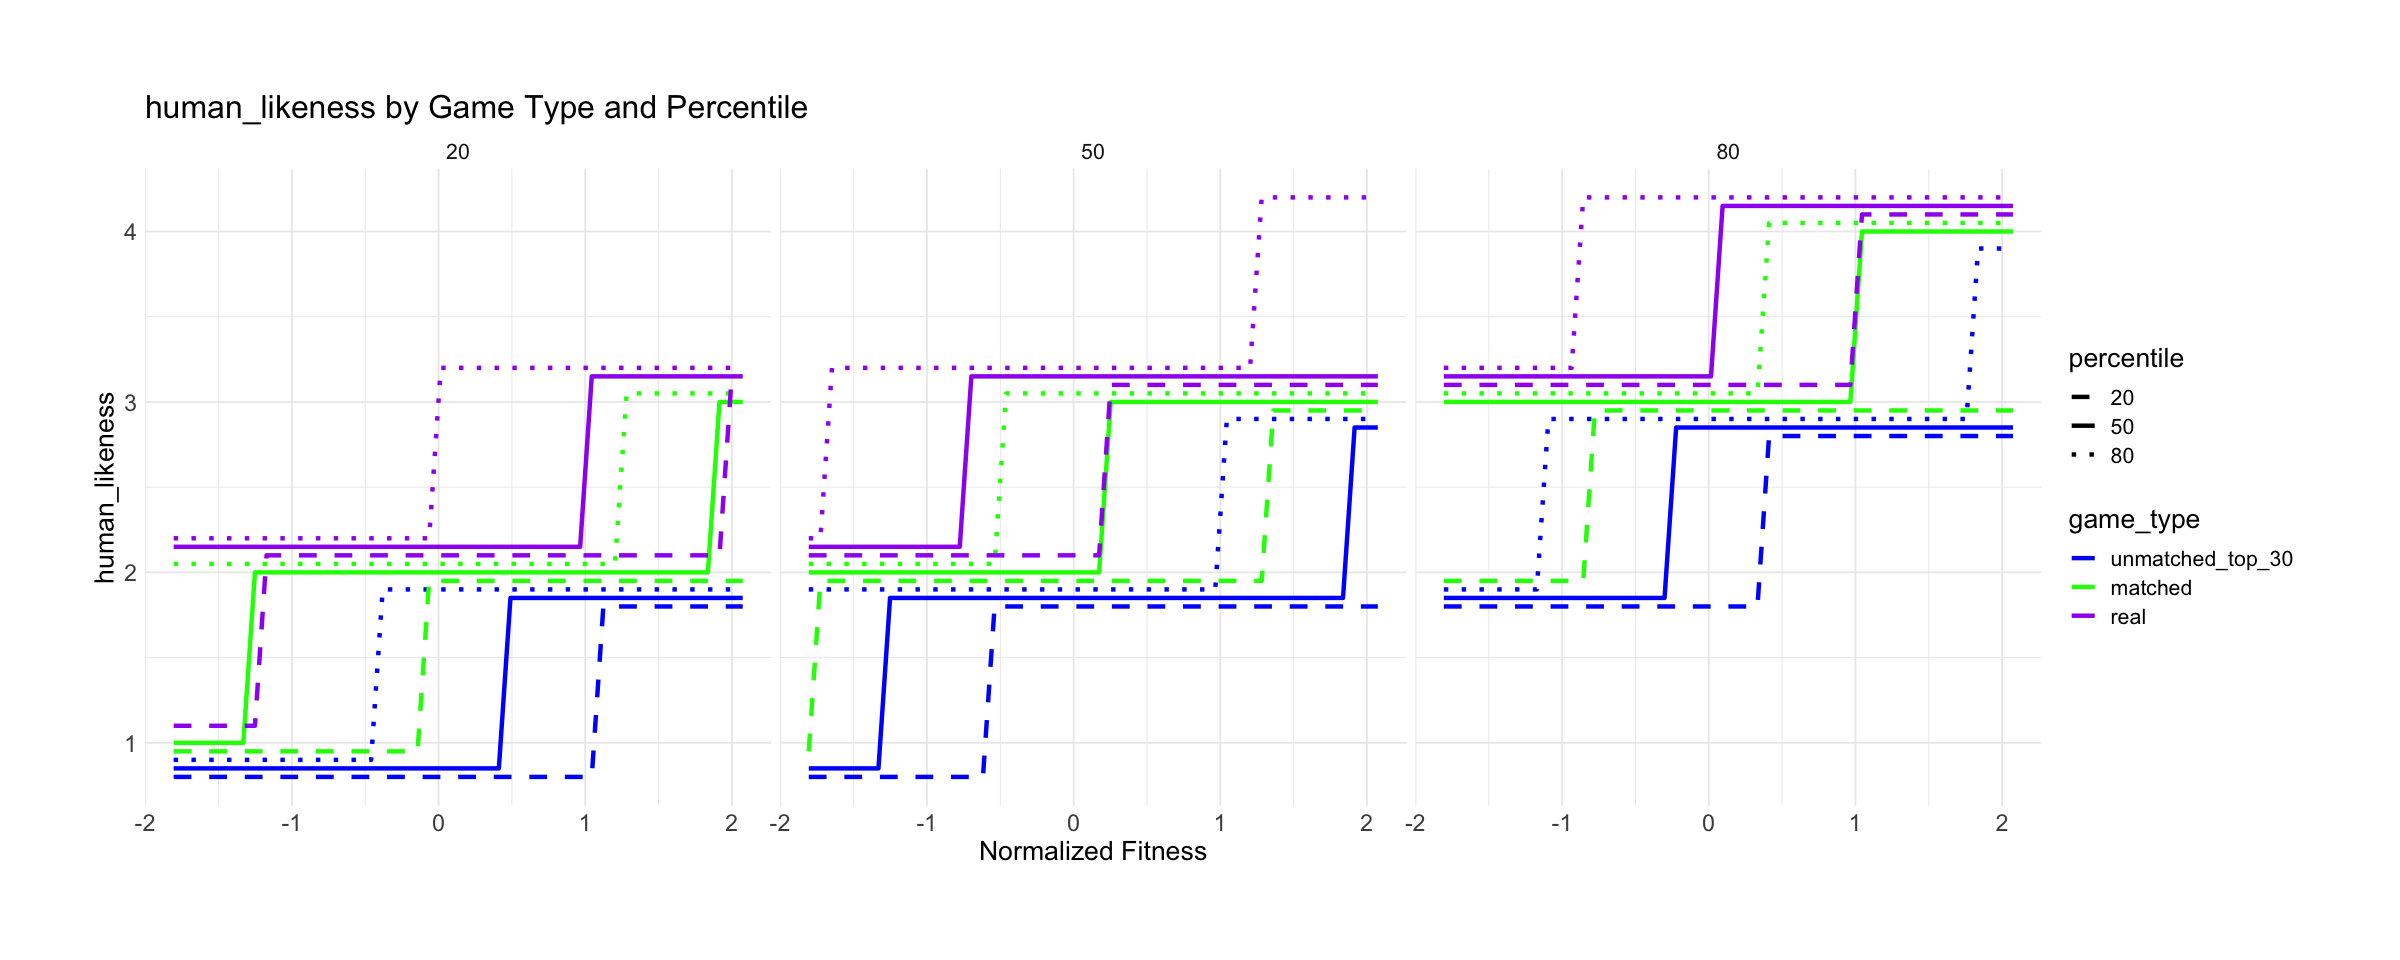

In [248]:

plotModelPredictions()



## Do we need a mixed effect for the games?

In [5]:
# Iterate through attributes
for (attr in ATTRIBUTES) {
    # Create formula with current attribute
    # attr.lmer_no_game_id <- lmer(formula = as.formula(glue("{attr} ~ 1 + game_type + normalized_fitness + (1 | participant_id)")), data = filtered_df)
    # attr.lmer_with_game_id <- update(attr.lmer_no_game_id, . ~ . + (1 + game_type | full_game_id))

    attr.mm_no_game_id <- clmm(
        formula = as.formula(glue("C({attr}) ~ 1 + C(game_type) + normalized_fitness + (1 | participant_id)")),
        data = filtered_df, Hess = TRUE
    )
    attr.mm_with_game_id <- clmm(
        formula = as.formula(glue("C({attr}) ~ 1 + C(game_type) + normalized_fitness + (1 | participant_id) + (1 | full_game_id)")),
        data = filtered_df, Hess = TRUE
    )

    anova_results <- anova(attr.mm_no_game_id, attr.mm_with_game_id)
    attr.aic_diff <- anova_results$AIC[[1]] - anova_results$AIC[[2]]
    attr.chisq <- anova_results$Chisq[[2]]
    attr.pvalue <- anova_results$`Pr(>Chisq)`[[2]] 
    # fixed_effects_aic <- AIC(logLik(attr.glm))
    # mixed_effects_aic <- AIC(logLik(attr.lmer))
    # aic_diff <- fixed_effects_aic - mixed_effects_aic
    print(glue("For {attr}, adding the game ID random effects results in AIC diff: {format(attr.aic_diff, nsmall=3)} | Chi-squared: {format(attr.chisq, nsmall=3)} | p-value: {format(attr.pvalue, nsmall=3)}"))
}

# anova(conf.model.without, conf.model.with)
# summary(confident_model)

For confident, adding the game ID random effects results in AIC diff: 49.03556 | Chi-squared: NULL | p-value: 9.070776e-13
For fun_play, adding the game ID random effects results in AIC diff: 39.63944 | Chi-squared: NULL | p-value: 1.097565e-10
For fun_watch, adding the game ID random effects results in AIC diff: 26.17496 | Chi-squared: NULL | p-value: 1.108294e-07
For capability, adding the game ID random effects results in AIC diff: -1.977122 | Chi-squared: NULL | p-value: 0.8797742
For goldilocks, adding the game ID random effects results in AIC diff: 108.3868 | Chi-squared: NULL | p-value: 8.062017e-26
For creativity, adding the game ID random effects results in AIC diff: 53.75391 | Chi-squared: NULL | p-value: 8.213478e-14
For human_likeness, adding the game ID random effects results in AIC diff: 29.1491 | Chi-squared: NULL | p-value: 2.389503e-08


Conclusion: we absolutely also need a mixed effect for the participants

## Let's analyze these now

## confident

### Mixed Effects Model

Cumulative Link Mixed Model fitted with the Laplace approximation

formula: C(confident) ~ 1 + C(game_type) + normalized_fitness + (1 | participant_id) +      (1 | full_game_id)
data:    filtered_df

 link  threshold nobs logLik   AIC     niter     max.grad cond.H 
 logit flexible  892  -1182.29 2382.59 736(2936) 5.97e-04 8.8e+01

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 1.2831   1.1327  
 full_game_id   (Intercept) 0.7669   0.8757  
Number of groups:  participant_id 100,  full_game_id 90 

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
C(game_type)matched   0.5253     0.2974   1.766   0.0773 .  
C(game_type)real      1.1511     0.2852   4.036 5.43e-05 ***
normalized_fitness    0.8459     0.1504   5.625 1.86e-08 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Threshold coefficients:
    Estimate Std. Error z value
1|2  -2.8097     0.2683 -10.471
2|3  -1.3675     0.2413  -5.666
3|4  -0.0

Warning message:
"contrasts dropped from factor C(game_type)"


### Marginal Means

 contrast                   estimate    SE  df z.ratio p.value
 matched - unmatched_top_30    0.525 0.297 Inf   1.766  0.1810
 real - unmatched_top_30       1.151 0.285 Inf   4.036  0.0002
 real - matched                0.626 0.305 Inf   2.055  0.0995

P value adjustment: tukey method for comparing a family of 3 estimates 

------------------

## fun_play

### Mixed Effects Model

Cumulative Link Mixed Model fitted with the Laplace approximation

formula: C(fun_play) ~ 1 + C(game_type) + normalized_fitness + (1 | participant_id) +      (1 | full_game_id)
data:    filtered_df

 link  threshold nobs logLik   AIC     niter     max.grad cond.H 
 logit flexible  892  -1134.46 2286.92 701(4369) 4.06e-04 6.8e+01

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 2.8697   1.6940  
 full_game_id   (Intercept) 0.5779   0.7602  
Number of groups:  participant_id 100,  full_game_id 90 

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
C(game_type)matched   0.6287     0.2736   2.298  0.02158 *  
C(game_type)real      1.0589     0.2633   4.021 5.79e-05 ***
normalized_fitness    0.3956     0.1347   2.936  0.00332 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Threshold coefficients:
    Estimate Std. Error z value
1|2  -0.9559     0.2597  -3.681
2|3   1.1138     0.2624   4.246
3|4   3.29

Warning message:
"contrasts dropped from factor C(game_type)"


### Marginal Means

 contrast                   estimate    SE  df z.ratio p.value
 matched - unmatched_top_30    0.629 0.274 Inf   2.298  0.0561
 real - unmatched_top_30       1.059 0.263 Inf   4.021  0.0002
 real - matched                0.430 0.273 Inf   1.577  0.2556

P value adjustment: tukey method for comparing a family of 3 estimates 

------------------

## fun_watch

### Mixed Effects Model

Cumulative Link Mixed Model fitted with the Laplace approximation

formula: C(fun_watch) ~ 1 + C(game_type) + normalized_fitness + (1 | participant_id) +      (1 | full_game_id)
data:    filtered_df

 link  threshold nobs logLik   AIC     niter     max.grad cond.H 
 logit flexible  892  -1077.05 2172.09 642(4301) 3.18e-04 6.8e+01

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 4.4133   2.1008  
 full_game_id   (Intercept) 0.5064   0.7116  
Number of groups:  participant_id 100,  full_game_id 90 

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
C(game_type)matched   0.6413     0.2656   2.414  0.01577 *  
C(game_type)real      0.9118     0.2571   3.547  0.00039 ***
normalized_fitness    0.1912     0.1302   1.469  0.14196    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Threshold coefficients:
    Estimate Std. Error z value
1|2  -0.7974     0.2862  -2.786
2|3   1.4145     0.2925   4.836
3|4   3.5

Warning message:
"contrasts dropped from factor C(game_type)"


### Marginal Means

 contrast                   estimate    SE  df z.ratio p.value
 matched - unmatched_top_30    0.641 0.266 Inf   2.414  0.0417
 real - unmatched_top_30       0.912 0.257 Inf   3.547  0.0011
 real - matched                0.271 0.264 Inf   1.025  0.5608

P value adjustment: tukey method for comparing a family of 3 estimates 

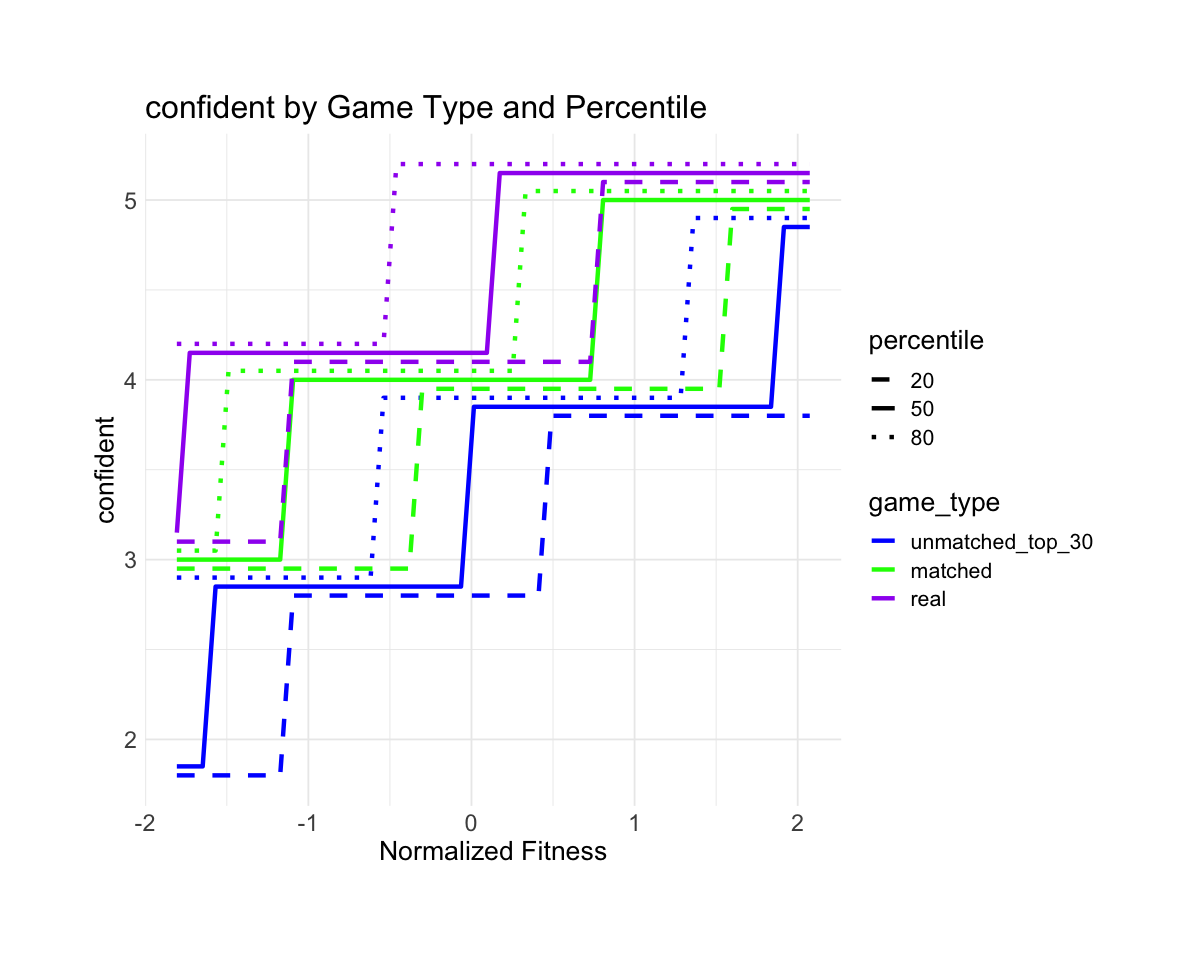

------------------

## capability

### Mixed Effects Model

Cumulative Link Mixed Model fitted with the Laplace approximation

formula: C(capability) ~ 1 + C(game_type) + normalized_fitness + (1 |      participant_id) + (1 | full_game_id)
data:    filtered_df

 link  threshold nobs logLik   AIC     niter     max.grad cond.H 
 logit flexible  892  -1191.32 2400.65 688(4093) 9.93e-04 4.9e+01

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 3.616444 1.90169 
 full_game_id   (Intercept) 0.007949 0.08916 
Number of groups:  participant_id 100,  full_game_id 90 

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)  
C(game_type)matched  0.34903    0.17045   2.048   0.0406 *
C(game_type)real     0.23183    0.16090   1.441   0.1496  
normalized_fitness  -0.18855    0.08719  -2.163   0.0306 *
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Threshold coefficients:
    Estimate Std. Error z value
1|2  -2.9044     0.2543 -11.420
2|3  -0.6740     0.2313  -2.914
3|4   1.1571    

Warning message:
"contrasts dropped from factor C(game_type)"


### Marginal Means

 contrast                   estimate    SE  df z.ratio p.value
 matched - unmatched_top_30    0.349 0.170 Inf   2.048  0.1010
 real - unmatched_top_30       0.232 0.161 Inf   1.441  0.3199
 real - matched               -0.117 0.167 Inf  -0.701  0.7630

P value adjustment: tukey method for comparing a family of 3 estimates 

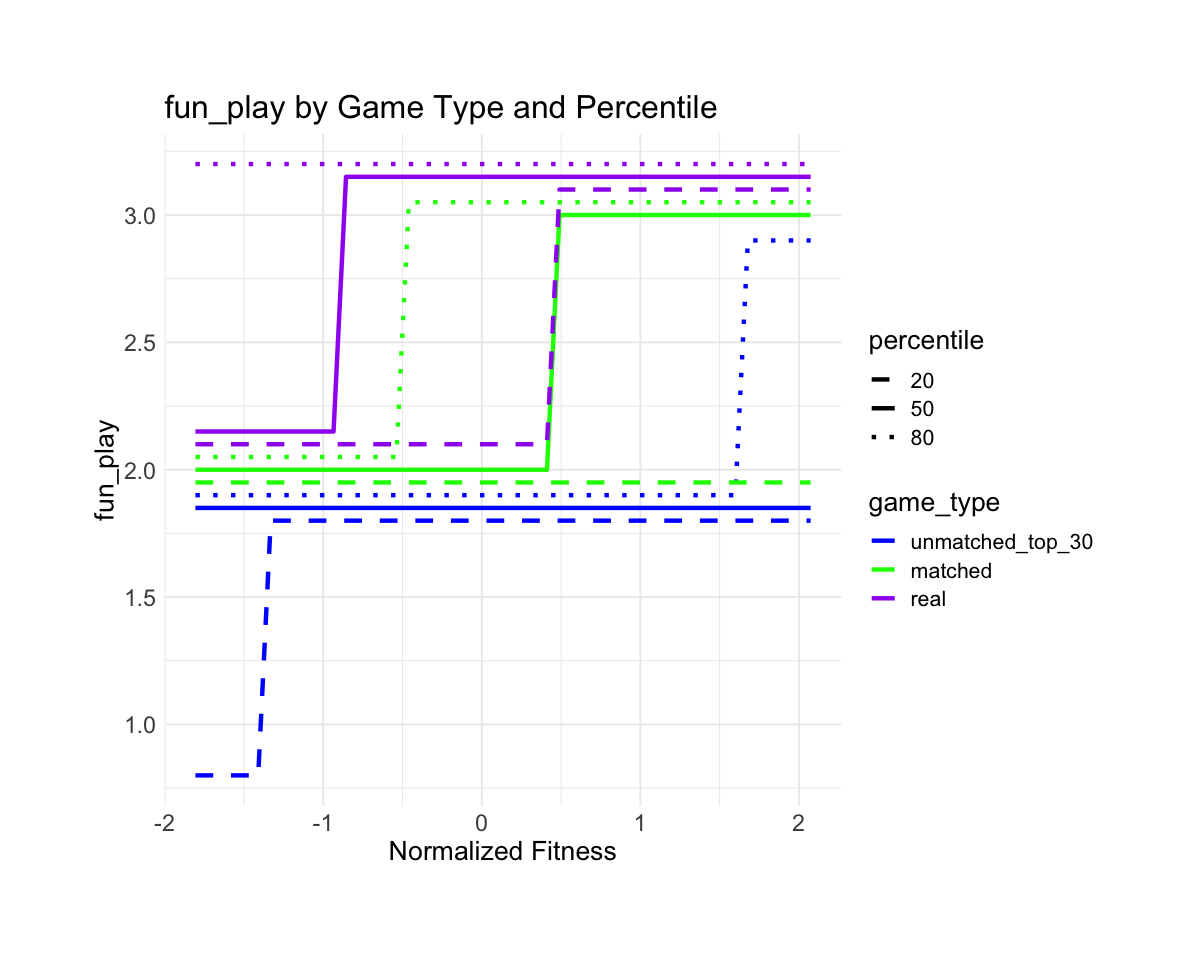

------------------

## goldilocks

### Mixed Effects Model

Cumulative Link Mixed Model fitted with the Laplace approximation

formula: C(goldilocks) ~ 1 + C(game_type) + normalized_fitness + (1 |      participant_id) + (1 | full_game_id)
data:    filtered_df

 link  threshold nobs logLik   AIC     niter     max.grad cond.H 
 logit flexible  892  -1106.95 2231.91 570(2858) 1.15e-03 8.2e+01

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 1.161    1.078   
 full_game_id   (Intercept) 1.256    1.121   
Number of groups:  participant_id 100,  full_game_id 90 

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
C(game_type)matched   0.3630     0.3529   1.029 0.303606    
C(game_type)real     -0.2498     0.3377  -0.740 0.459500    
normalized_fitness   -0.5878     0.1707  -3.443 0.000576 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Threshold coefficients:
    Estimate Std. Error z value
1|2  -2.3600     0.2832  -8.335
2|3  -0.7327     0.2700  -2.713
3|4   2.

Warning message:
"contrasts dropped from factor C(game_type)"


### Marginal Means

 contrast                   estimate    SE  df z.ratio p.value
 matched - unmatched_top_30    0.363 0.353 Inf   1.029  0.5587
 real - unmatched_top_30      -0.250 0.338 Inf  -0.740  0.7399
 real - matched               -0.613 0.355 Inf  -1.725  0.1957

P value adjustment: tukey method for comparing a family of 3 estimates 

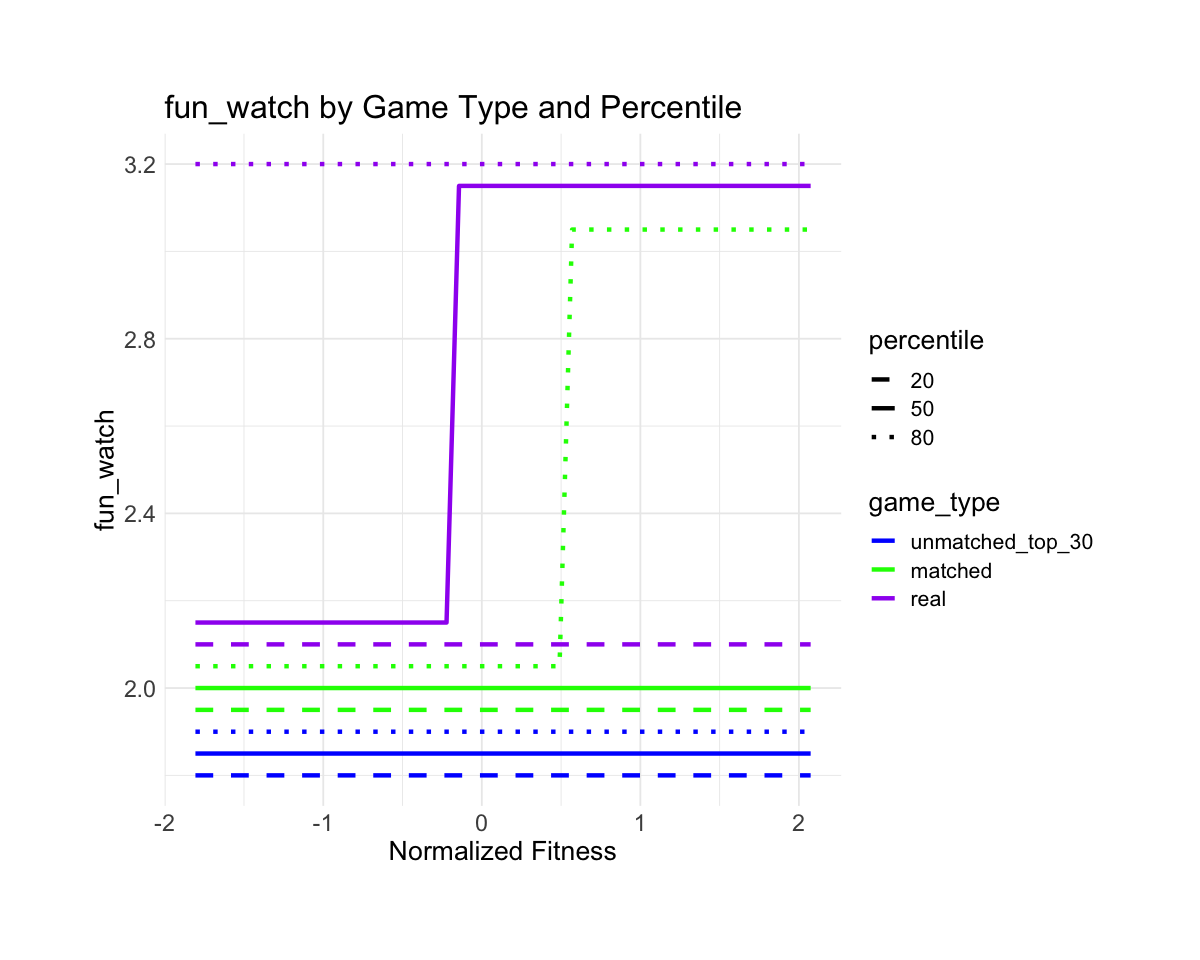

------------------

## creativity

### Mixed Effects Model

Cumulative Link Mixed Model fitted with the Laplace approximation

formula: C(creativity) ~ 1 + C(game_type) + normalized_fitness + (1 |      participant_id) + (1 | full_game_id)
data:    filtered_df

 link  threshold nobs logLik   AIC     niter     max.grad cond.H 
 logit flexible  892  -1076.82 2171.64 648(3603) 5.29e-04 7.1e+01

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 2.9318   1.7122  
 full_game_id   (Intercept) 0.8534   0.9238  
Number of groups:  participant_id 100,  full_game_id 90 

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)   
C(game_type)matched   0.5507     0.3102   1.776  0.07581 . 
C(game_type)real      0.4377     0.2983   1.467  0.14227   
normalized_fitness   -0.4863     0.1524  -3.191  0.00142 **
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Threshold coefficients:
    Estimate Std. Error z value
1|2  -1.2302     0.2820  -4.362
2|3   1.0634     0.2822   3.769
3|4   3.3883

Warning message:
"contrasts dropped from factor C(game_type)"


### Marginal Means

 contrast                   estimate    SE  df z.ratio p.value
 matched - unmatched_top_30    0.551 0.310 Inf   1.776  0.1778
 real - unmatched_top_30       0.438 0.298 Inf   1.467  0.3067
 real - matched               -0.113 0.310 Inf  -0.364  0.9296

P value adjustment: tukey method for comparing a family of 3 estimates 

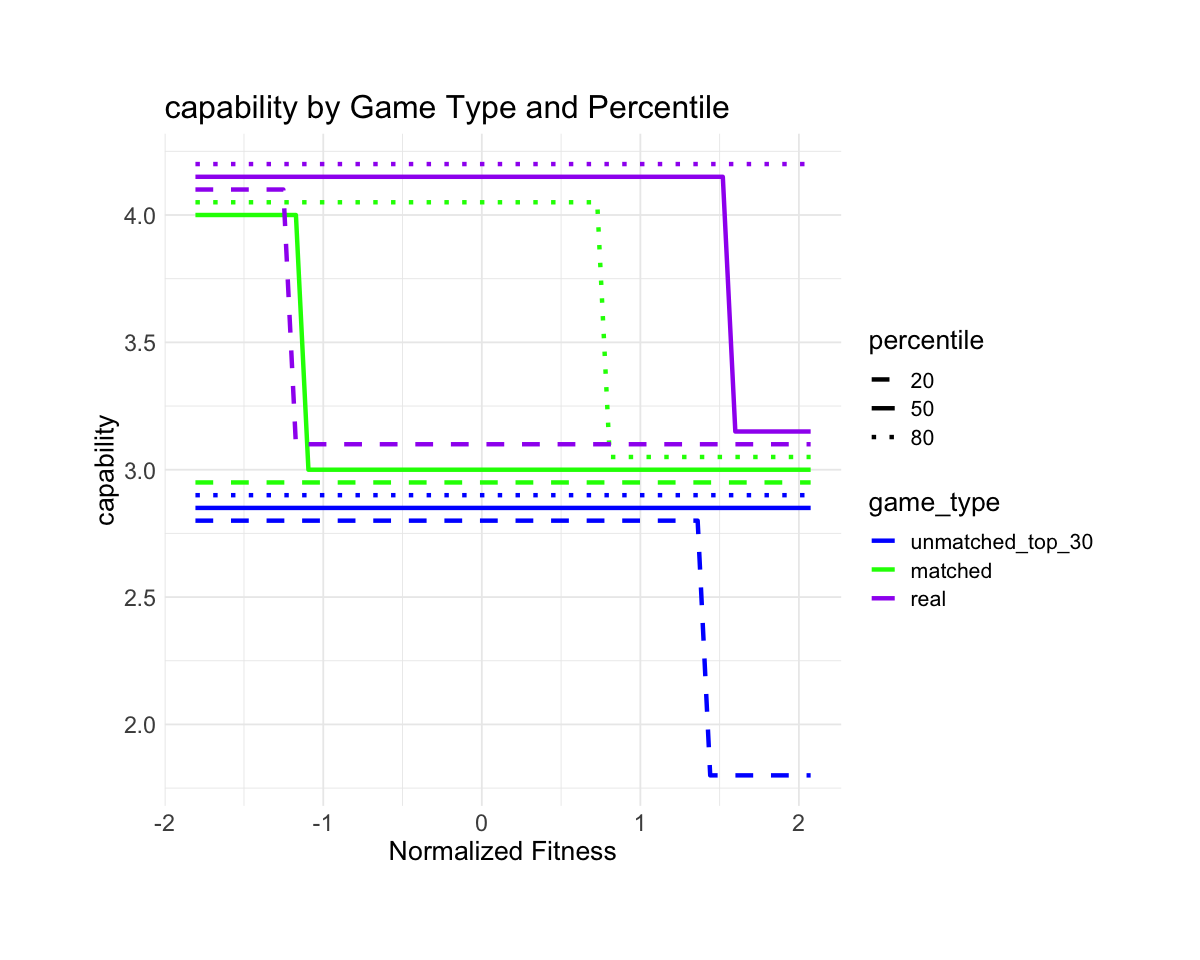

------------------

## human_likeness

### Mixed Effects Model

Cumulative Link Mixed Model fitted with the Laplace approximation

formula: C(human_likeness) ~ 1 + C(game_type) + normalized_fitness + (1 |      participant_id) + (1 | full_game_id)
data:    filtered_df

 link  threshold nobs logLik   AIC     niter     max.grad cond.H 
 logit flexible  892  -1215.28 2448.56 718(3576) 5.66e-04 7.5e+01

Random effects:
 Groups         Name        Variance Std.Dev.
 participant_id (Intercept) 1.951    1.3967  
 full_game_id   (Intercept) 0.544    0.7375  
Number of groups:  participant_id 100,  full_game_id 90 

Coefficients:
                    Estimate Std. Error z value Pr(>|z|)    
C(game_type)matched   0.8368     0.2676   3.128  0.00176 ** 
C(game_type)real      1.4455     0.2583   5.597 2.18e-08 ***
normalized_fitness    0.5698     0.1320   4.316 1.59e-05 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Threshold coefficients:
    Estimate Std. Error z value
1|2  -0.8014     0.2376  -3.373
2|3   0.9950     0.2399   4.148
3|4 

Warning message:
"contrasts dropped from factor C(game_type)"


### Marginal Means

 contrast                   estimate    SE  df z.ratio p.value
 matched - unmatched_top_30    0.837 0.268 Inf   3.128  0.0050
 real - unmatched_top_30       1.446 0.258 Inf   5.597  <.0001
 real - matched                0.609 0.265 Inf   2.299  0.0559

P value adjustment: tukey method for comparing a family of 3 estimates 

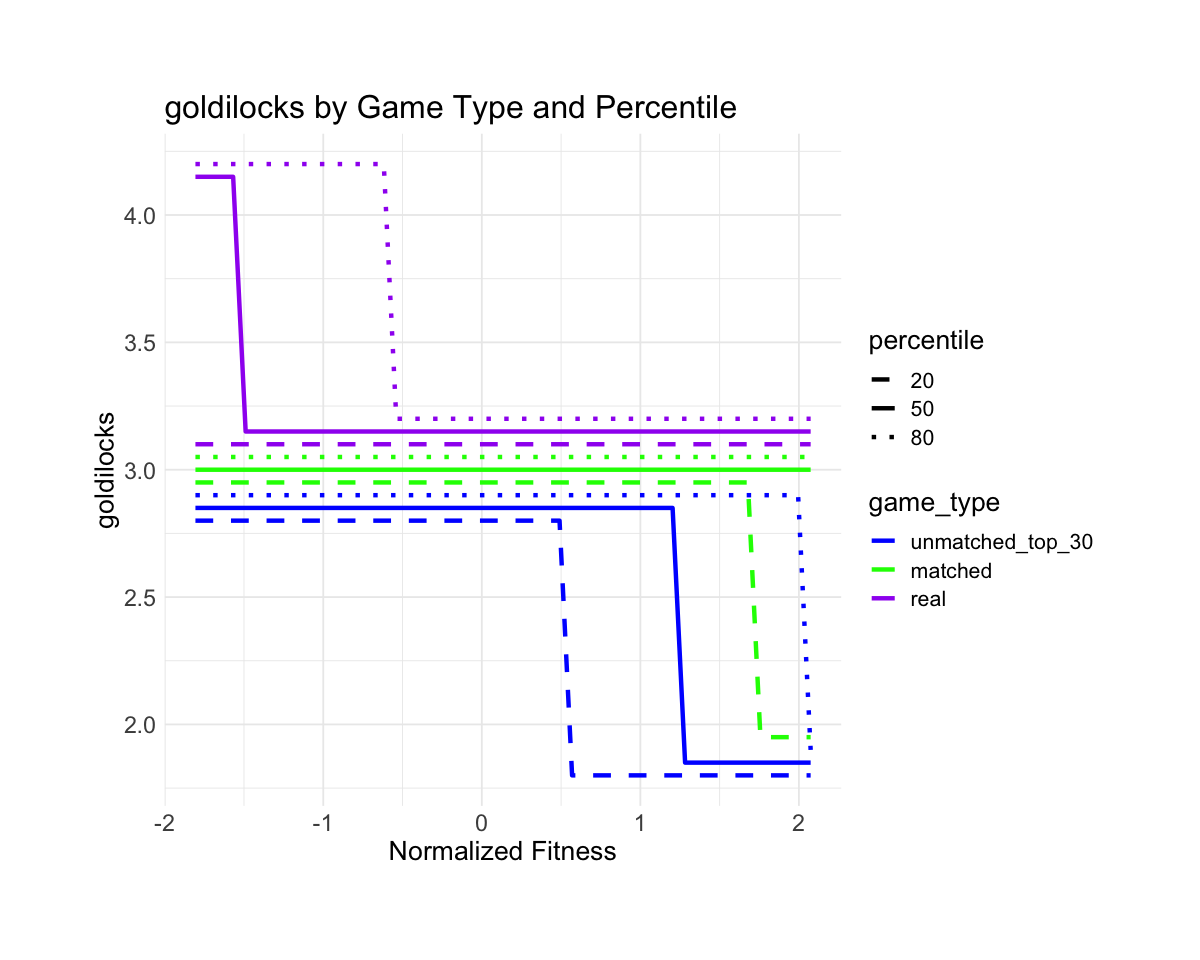

------------------

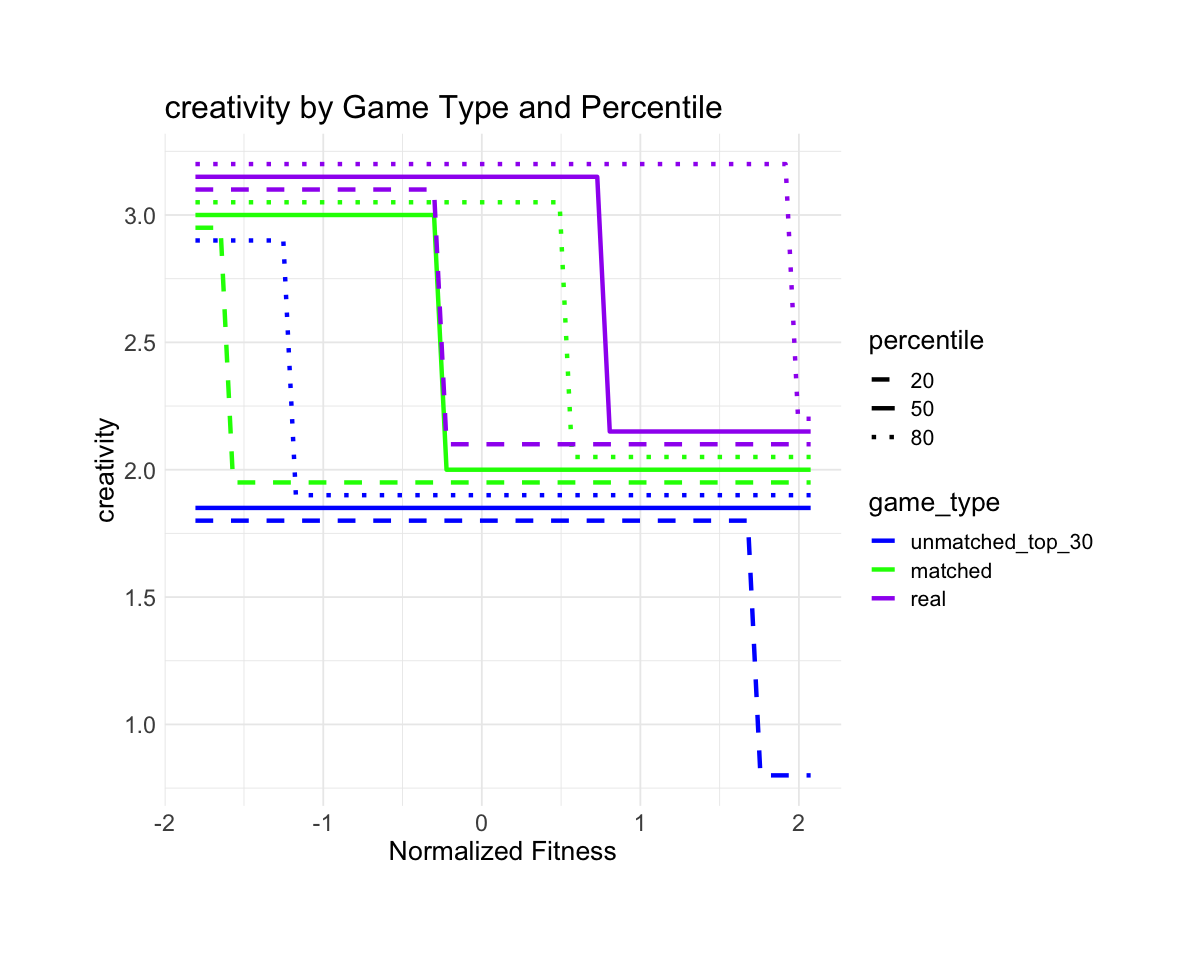

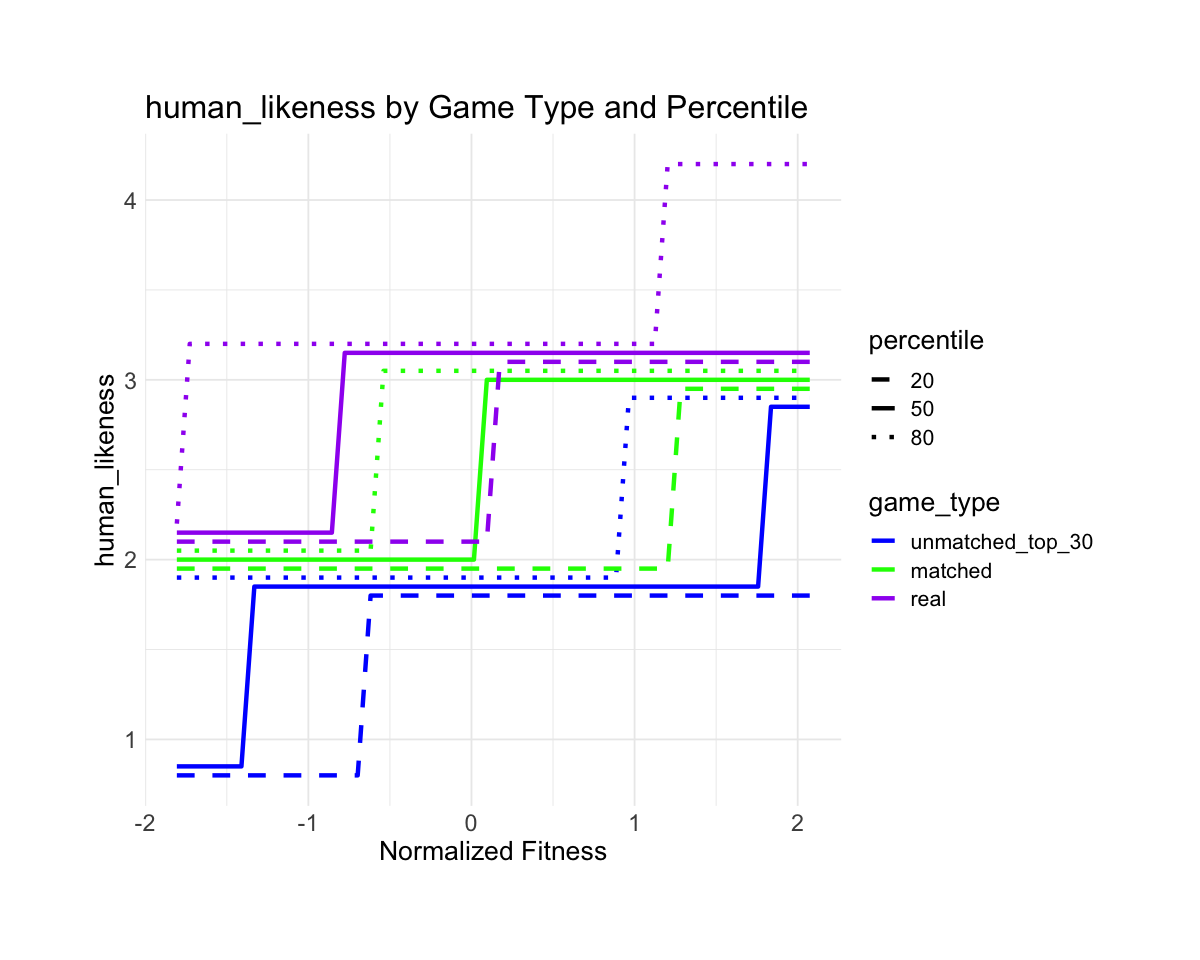

In [175]:
for (attr in ATTRIBUTES) {
    display_markdown(glue("## {attr}"))

    # Create formula with current attribute
    # attr.lmer <- lmer(formula = as.formula(glue("{attr} ~ 1 + game_type + normalized_fitness + (1 | participant_id) + (game_type | full_game_id)")), data = filtered_df)

    attr.mm <- clmm(
        formula = as.formula(glue("C({attr}) ~ 1 + C(game_type) + normalized_fitness + (1 | participant_id) + (1 | full_game_id)")),
        data = filtered_df, Hess = TRUE
    )

    display_markdown("### Mixed Effects Model")    
    display(summary(attr.mm))

    attr.marginal_means = emmeans(attr.mm, "game_type")
    display_markdown("### Marginal Means")
    display(pairs(attr.marginal_means, reverse = TRUE))

    plotModelPredictions(attr.mm);
    ggplot()


    display_markdown("------------------")

    # anova_results <- anova(attr.lmer_no_participant, attr.lmer_with_participant)
    # attr.chisq <- anova_results$Chisq[[2]]
    # attr.pvalue <- anova_results$`Pr(>Chisq)`[[2]] 
    # # fixed_effects_aic <- AIC(logLik(attr.glm))
    # # mixed_effects_aic <- AIC(logLik(attr.lmer))
    # # aic_diff <- fixed_effects_aic - mixed_effects_aic
    # print(glue("For {attr}, adding the participant ID random effects results in Chi-squared: {format(attr.chisq, nsmall=3)} | p-value: {format(attr.pvalue, nsmall=3)}"))

}


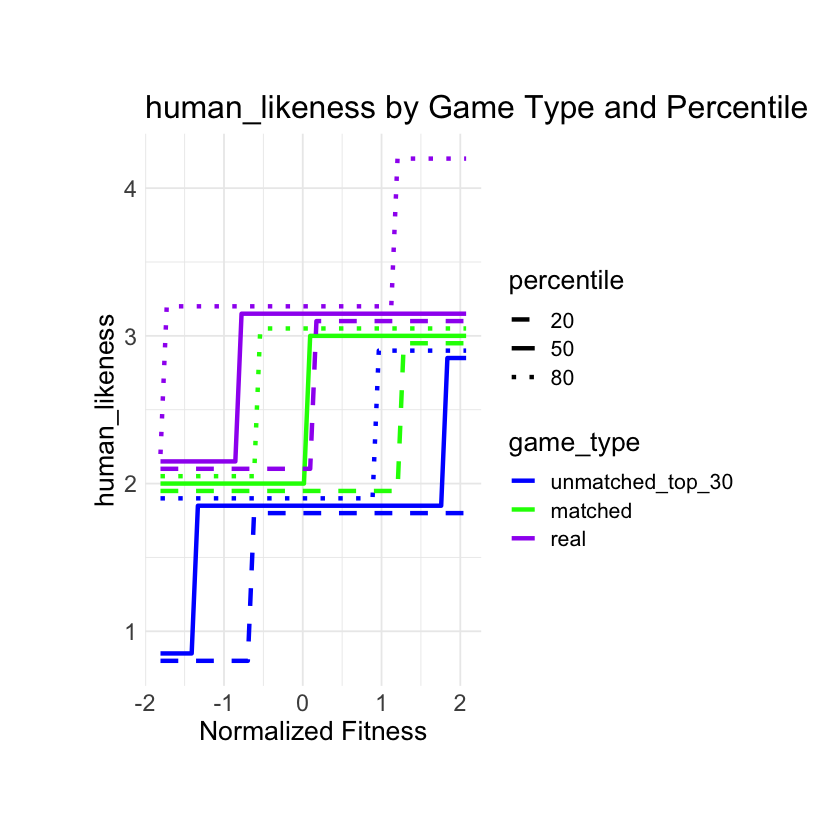

In [148]:
N_POINTS = 50

fitness.min <- min(filtered_df$normalized_fitness)
fitness.max <- max(filtered_df$normalized_fitness)

# Generate a sequence of numbers from 0 to 1 with 10 equally spaced points
fitness.seq <- seq(fitness.min, fitness.max, length.out = N_POINTS)

# Create a data frame with a row for each sequence of fitness values for each game type
predict_data_df <- expand.grid(normalized_fitness = fitness.seq, game_type = levels(filtered_df$game_type))

# replicate each row 3 times (once for each percentile)
predict_data_df <- predict_data_df[rep(row.names(predict_data_df), each = 3),]


predict_data_df <- predict_data_df %>%
    mutate(percentile = rep(c(20, 50, 80), times = N_POINTS * 3)) %>%
    mutate(percentile = as.factor(percentile))

head(predict_data_df)





,normalized_fitness,game_type,percentile
,<dbl>,<fct>,<fct>
1,-1.806326,unmatched_top_30,20
1.1,-1.806326,unmatched_top_30,50
1.2,-1.806326,unmatched_top_30,80
2,-1.727135,unmatched_top_30,20
2.1,-1.727135,unmatched_top_30,50
2.2,-1.727135,unmatched_top_30,80


In [149]:
attr.game_effects_df <- ranef(attr.mm)$full_game_id
colnames(attr.game_effects_df)[1] <- c("effect")
attr.game_effects_df <- rownames_to_column(attr.game_effects_df, var = "full_game_id")
attr.game_effects_df$full_game_id <- factor(attr.game_effects_df$full_game_id, levels = levels(filtered_df$full_game_id))

limited_filtered_df <- filtered_df %>%
    select(full_game_id, game_type) %>%
    distinct()

attr.game_effects_df <-
    left_join(attr.game_effects_df, limited_filtered_df, by = "full_game_id")


percentiles <- attr.game_effects_df %>%
    group_by(game_type) %>%
    summarize(percentile_20 = quantile(effect, 0.20),
              percentile_50 = quantile(effect, 0.50),
              percentile_80 = quantile(effect, 0.80)) %>%
    pivot_longer(cols = starts_with("percentile"),
                 names_to = "percentile",
                 values_to = "game_effect") %>%
    mutate(percentile = gsub("percentile_", "", percentile)) %>%
    mutate(percentile = as.factor(percentile))

predict_data_df <-
    left_join(predict_data_df, percentiles, by = c("game_type", "percentile"))
    

head(predict_data_df)


,normalized_fitness,game_type,percentile,game_effect
,<dbl>,<fct>,<fct>,<dbl>
1,-1.806326,unmatched_top_30,20,-0.4131830
2,-1.806326,unmatched_top_30,50,-0.0247835
3,-1.806326,unmatched_top_30,80,0.4781828
4,-1.727135,unmatched_top_30,20,-0.4131830
5,-1.727135,unmatched_top_30,50,-0.0247835
6,-1.727135,unmatched_top_30,80,0.4781828


In [150]:
attr.coef <- coef(attr.mm)
fitness_coef <- attr.coef[length(attr.coef)]
coef.df <- as.data.frame(attr.coef[5:(length(attr.coef) - 1)])
colnames(coef.df)[1] <- "game_type_intercept"
row_names <- rownames(coef.df)
row_names <- gsub("C\\(game_type\\)", "", row_names)
rownames(coef.df) <- row_names

coef.df <- rownames_to_column(coef.df, var = "game_type")
coef.df <- rbind(coef.df, c(game_type = "unmatched_top_30", game_type_intercept = 0))
coef.df$game_type <- as.factor(coef.df$game_type)
coef.df$game_type_intercept <- as.numeric(coef.df$game_type_intercept)

coef.df

game_type,game_type_intercept
<fct>,<dbl>
matched,0.8368229
real,1.4455301
unmatched_top_30,0.0000000


In [151]:
merged_predict_df <- 
    merge(predict_data_df, coef.df, by = "game_type", all.x = TRUE) %>%
    # add the prediction
    mutate(prediction = (merged_predict_df$game_type_intercept + fitness_coef * merged_predict_df$normalized_fitness + merged_predict_df$game_effect)) %>%
    # bin the prediction
    mutate(bin = cut(prediction, breaks = c(-Inf, attr.coef[1:4], Inf), labels = 1:5, include.lowest = TRUE)) %>%
    mutate(bin = as.double(bin)) %>%
    # Add 0.1 if game type is 'matched' and 0.2 if game type is 'real'
    mutate(bin = ifelse(game_type == 'unmatched_top_30', bin - 0.15, bin)) %>%
    mutate(bin = ifelse(game_type == 'real', bin + 0.15, bin)) %>%
    mutate(bin = ifelse(percentile == 20, bin - 0.05, bin)) %>%
    mutate(bin = ifelse(percentile == 80, bin + 0.05, bin))

# View the binned dataframe
head(merged_predict_df)

,game_type,normalized_fitness,percentile,game_effect,game_type_intercept,prediction,bin
,<fct>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,matched,-1.806326,20,-0.5602304,0.8368229,-1.14623770,0.95
2,matched,-1.806326,50,0.1045211,0.8368229,-0.08788540,2.00
3,matched,-1.806326,80,0.4722916,0.8368229,0.46992881,2.05
4,matched,-1.727135,20,-0.5602304,0.8368229,-1.10111518,0.95
5,matched,-1.727135,50,0.1045211,0.8368229,-0.04276289,2.00
6,matched,-1.727135,80,0.4722916,0.8368229,0.51505132,2.05


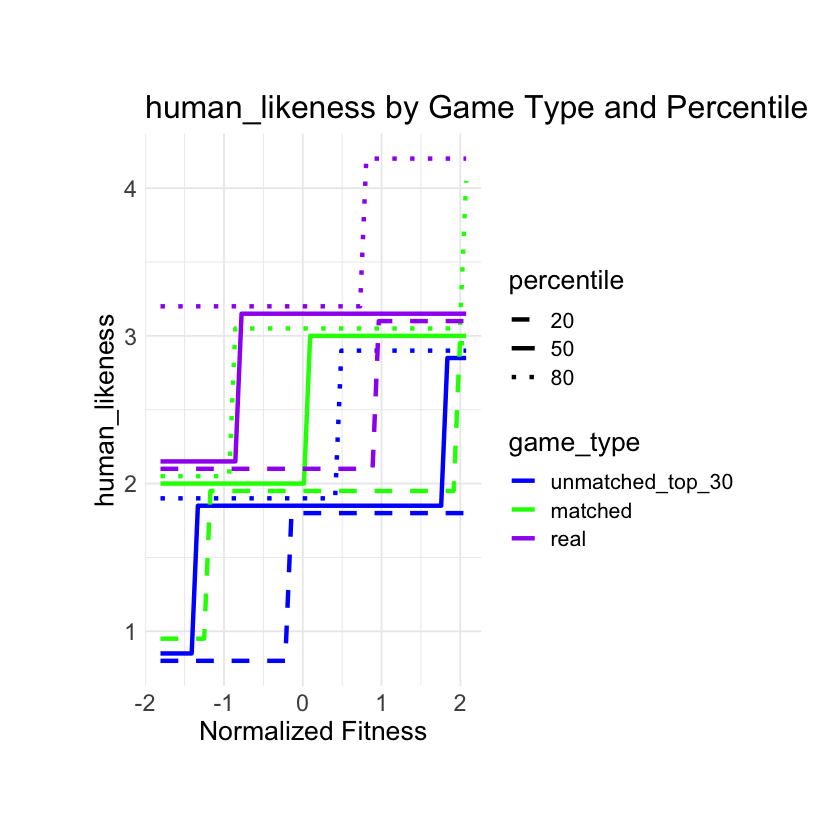

In [162]:
ggplot(merged_predict_df, aes(x = normalized_fitness, y = bin, color = game_type, linetype = percentile)) +
    geom_line(size = 1.25) +
    labs(x = "Normalized Fitness", y = attr) +
    scale_color_manual(values = c("unmatched" = "red", "unmatched_top_30" = "blue", "matched" = "green", "real" = "purple")) +
    scale_linetype_manual(values = c("20" = "dashed", "50" = "solid", "80" = "dotted")) +
    theme_minimal() +
    theme(
        plot.margin = margin(2, 2, 2, 2, "cm"),
        text = element_text(size = 16),
        axis.text = element_text(size = 14),
    ) + 
    ggtitle(glue("{attr} by Game Type and Percentile"))


In [73]:
max(merged_predict_df$prediction)

[1] 2.627304

In [ ]:
strictControl <- lmerControl(optCtrl = list(
   algorithm = "NLOPT_LN_NELDERMEAD",
   xtol_abs = 1e-12,
   ftol_abs = 1e-12))

# full_normalized_confident ~ 1 + normalized_fitness + game_type + (1 | participant_id) + (1 | full_game_id), 
l <- lmer(formula = full_normalized_confident ~ 1  + game_type + (1 | full_game_id), 
    data = filtered_df, control = strictControl)

summary(l)

In [ ]:
confident_means = emmeans(confident_model, "game_type")
print(pairs(confident_means, reverse = TRUE))
print(pwpm(confident_means, reverse = TRUE))

In [ ]:
mm <- clmm(C(confident) ~ C(game_type) + normalized_fitness + (1 | participant_id) + (1 | full_game_id),
    # random = d +  , # + (1 | full_game_id), 
    data = filtered_df,
    Hess = TRUE
    )

summary(mm)

In [ ]:
emmeans(mm, "game_type")